# Seq2Seq Modeling for Position Inference

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '..')

from pathlib import Path
import math, random, os, time

import torch
from torch import nn, optim, Tensor
import torch.nn.functional as F

import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler

from src.common.data_utils import *
from src.common.models import *
from src.common.training_utils import *

torch.manual_seed(0)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset Management

In [5]:
data_path = Path('../../csv-files')
filenames = os.listdir(data_path)

orientation_requests = {'Orientation' : ['T12', 'RightUpperArm', 'RightForeArm']}
position_requests = {'Position' : ['Pelvis', 'RightForeArm']}
num_files = 5
seq_length = 20

In [5]:
orientation, orientation_scaler = read_data(filenames, data_path, num_files, orientation_requests, seq_length)

position, position_scaler = read_data(filenames, data_path, num_files, position_requests,  seq_length, request_type='Position')

Done with reading files
Number of frames in dataset: 2041420
Number of bytes: 195976320


KeyboardInterrupt: 

In [6]:
position = np.flip(position, axis=1).copy()

In [7]:
encoder_input_data, decoder_target_data = orientation, position

batch_size = 32
encoder_input_data = discard_remainder(encoder_input_data, batch_size)
decoder_target_data = discard_remainder(decoder_target_data, batch_size)

encoder_feature_size = encoder_input_data.shape[-1]
decoder_feature_size = decoder_target_data.shape[-1]

## Refactor using Dataset


In [8]:
from torch.utils.data import TensorDataset, DataLoader, random_split

In [9]:
encoder_input_data = torch.tensor(encoder_input_data).to(device)
decoder_target_data = torch.tensor(decoder_target_data).to(device)

In [10]:
dataset = TensorDataset(encoder_input_data, decoder_target_data)

train_size_approx = int(0.8 * len(dataset))
train_size = train_size_approx - (train_size_approx % batch_size)
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [12]:
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))

Number of training samples: 81632
Number of validation samples: 20416


## Training

In [13]:
def get_encoder(num_features, hidden_size=64, lr=0.001, dropout=0.0, bs=batch_size, bidirectional=False):
    encoder = EncoderRNN(num_features, hidden_size, bs, dropout=dropout, bidirectional=bidirectional).to(device)
    return encoder, optim.Adam(encoder.parameters(), lr=lr)

def get_decoder(num_features, hidden_size=64, lr=0.001, dropout=0.0, bs=batch_size):
    decoder = DecoderRNN(num_features, hidden_size, num_features, bs, dropout=dropout).to(device)
    return decoder, optim.Adam(decoder.parameters(), lr=lr)

def get_attn_decoder(num_features, method, hidden_size=64, lr=0.001, bs=batch_size, bidirectional_encoder=False):
    attn = Attention(hidden_size, bs, method, bidirectional_encoder=bidirectional_encoder)
    decoder = AttnDecoderRNN(num_features, num_features, hidden_size, hidden_size, attn, bidirectional_encoder=bidirectional_encoder).to(device)
    return decoder, optim.Adam(decoder.parameters(), lr=lr)

In [16]:
epochs = 1

dataloaders = (train_dataloader, val_dataloader)

criterion = nn.L1Loss()

## Training the seq2seq model

Epoch 1/1
81632/81632 [==============================] - Time elapsed: 36.37s - Loss: 0.15975577
Training Loss: 0.29632406 - Val Loss: 0.15381813 - Scaled Val Loss: 0.02081385


<Figure size 432x288 with 0 Axes>

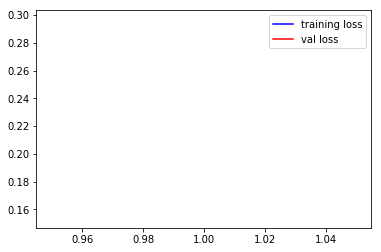

<Figure size 432x288 with 0 Axes>

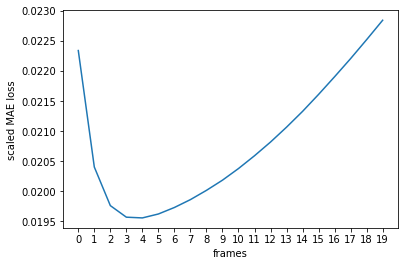

In [19]:
encoder, encoder_opt = get_encoder(encoder_feature_size)
decoder, decoder_opt = get_decoder(decoder_feature_size)

models = (encoder, decoder)
opts = (encoder_opt, decoder_opt)

fit(models, opts, epochs, dataloaders, criterion, position_scaler)

## Training the seq2seq model with a bidirectional encoder

In [ ]:
encoder, encoder_opt = get_encoder(encoder_feature_size, bidirectional=True)
decoder, decoder_opt = get_decoder(decoder_feature_size)

models = (encoder, decoder)
opts = (encoder_opt, decoder_opt)

fit(models, opts, epochs, dataloaders, criterion, position_scaler)

## Training the seq2seq model with attention

In [ ]:
encoder, encoder_opt = get_encoder(encoder_feature_size)
decoder, decoder_opt = get_attn_decoder(decoder_feature_size, 'general')

models = (encoder, decoder)
opts = (encoder_opt, decoder_opt)

fit(models, opts, epochs, dataloaders, criterion, position_scaler, use_attention=True)

## Training the seq2seq model with bidirectional encoder and attention

In [ ]:
encoder, encoder_opt = get_encoder(encoder_feature_size, bidirectional=True)
decoder, decoder_opt = get_attn_decoder(decoder_feature_size, 'general', bidirectional_encoder=True)

models = (encoder, decoder)
opts = (encoder_opt, decoder_opt)

fit(models, opts, epochs, dataloaders, criterion, position_scaler, use_attention=True)